In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

from nanonets.utils import fft, harmonic_strength, total_harmonic_distortion, BLUE_COLOR

plt.style.use(["science","bright","grid"])
PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"

In [18]:
AMPLITUDE_LIST  = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08]
FREQ_LIST_MHZ   = [0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.]
# [0.002,0.005,266.,610.,1200.,2400.,4800.,9600.]  
N_PERIODS       = 100

### Electric Current

In [19]:
e_type  = 'constant'
dts     = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time    = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data    = {amp : {freq : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

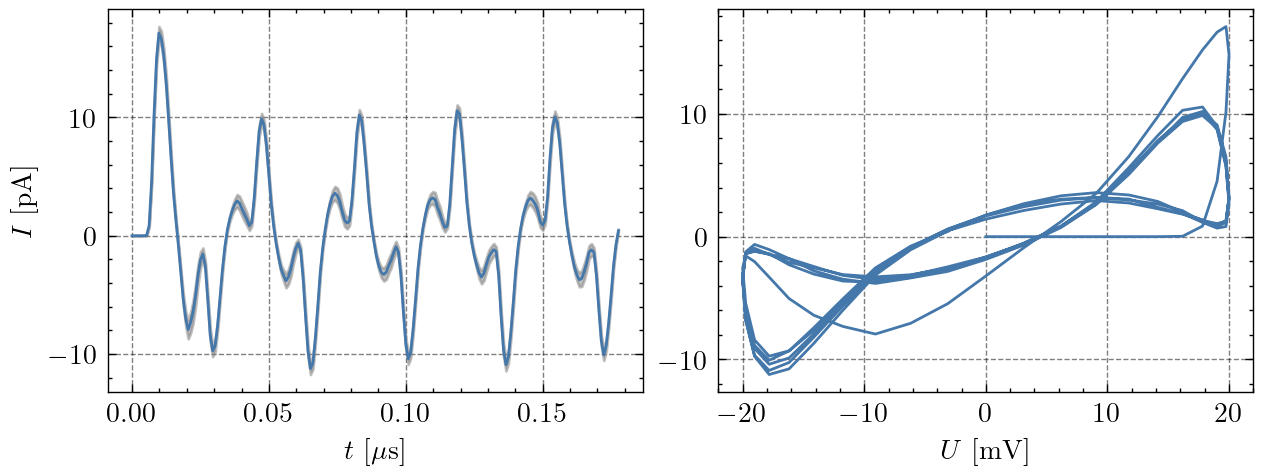

In [35]:
freq = 28.0
amp  = 0.02
n_p  = 2
t    = time[freq][:-1]*1e6
x    = data[amp][freq]['E0'].values*1000
y    = data[amp][freq]['Observable'].values*1e-6
y_e  = data[amp][freq]['Error'].values*1e-6

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
fig.set_figheight(fig.get_figheight()*0.9)
ax1 = fig.add_subplot(1,2,1)
ax1.plot(t[:n_p*N_PERIODS], y[:n_p*N_PERIODS])
ax1.fill_between(t[:n_p*N_PERIODS], y[:n_p*N_PERIODS]-y_e[:n_p*N_PERIODS], y[:n_p*N_PERIODS]+y_e[:n_p*N_PERIODS], alpha=0.5, color='grey')
ax1.set_xlabel("$t$ [$\mu$s]")
ax1.set_ylabel("$I$ [pA]")
ax1 = fig.add_subplot(1,2,2)
ax1.plot(x[:n_p*N_PERIODS], y[:n_p*N_PERIODS])
ax1.set_xlabel("$U$ [mV]")

fig.savefig(f"plots/amp_freq/{e_type}_signal_{freq:.3f}_{amp:.3f}.svg", transparent=True)

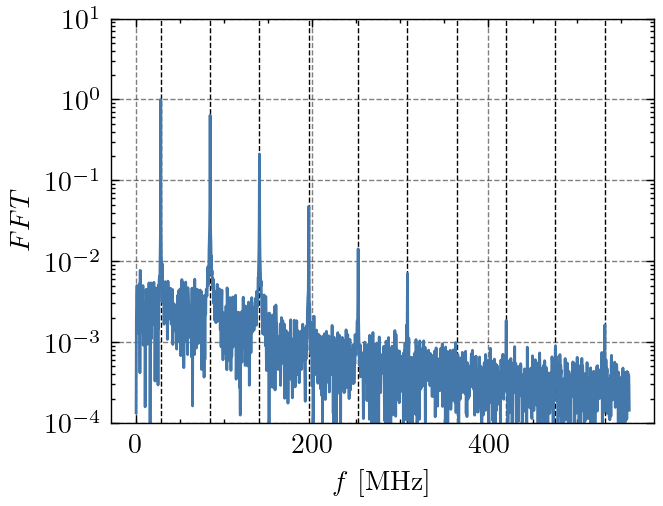

In [36]:
freq = 28.
amp  = 0.02
n_p  = 4
dt   = dts[freq]
y    = data[amp][freq]['Observable'].values*1e-6

xf, yf  = fft(y[n_p*N_PERIODS:], dt=dt)
fig, ax = plt.subplots(dpi=200)
for i in [1,3,5,7,9,11,13,15,17,19]:
    ax.vlines(i*freq, 1e-4, 1e1, color='black', ls='--', lw=.5)

ax.plot(xf*1e-6, yf/np.max(yf))
ax.set_yscale('log')
# ax.set_xlim(0.0,200)
ax.set_ylim(1e-4, 1e1)
ax.set_xlabel("$f$ [MHz]")
ax.set_ylabel("$FFT$")

fig.savefig(f"plots/amp_freq/{e_type}_fft_{freq:.3f}_{amp:.3f}.svg", transparent=True)

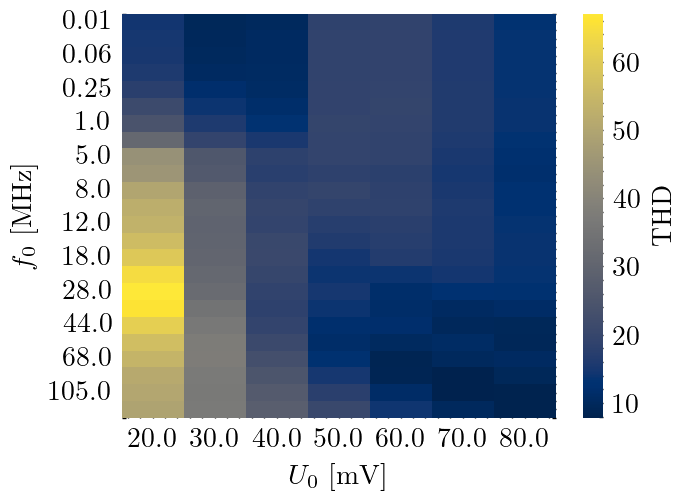

In [38]:
thd_arr = pd.DataFrame([[total_harmonic_distortion(signal=data[amp][freq]['Observable'].values, f0=freq*1e6, dt=dts[freq], N_f=18) 
                         for amp in AMPLITUDE_LIST[1:]] for freq in FREQ_LIST_MHZ], columns=np.array(AMPLITUDE_LIST[1:])*1000, index=FREQ_LIST_MHZ)
fig, ax = plt.subplots(dpi=200)
ax      = sns.heatmap(thd_arr, cmap='cividis', ax=ax, cbar_kws={'label':'THD'}, annot=False)
_       = plt.yticks(rotation=0)
_       = ax.set_ylabel("$f_0$ [MHz]")
_       = ax.set_xlabel("$U_0$ [mV]")

fig.savefig(f"plots/amp_freq/{e_type}_thd_map.svg", transparent=True)

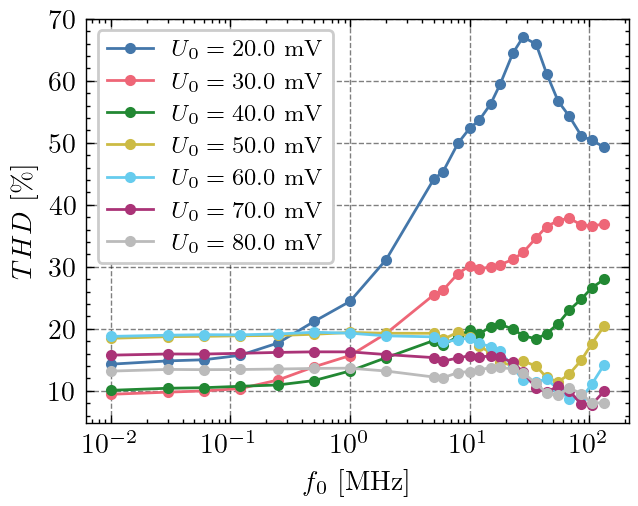

In [43]:
fig, ax = plt.subplots(dpi=200)
for amp in AMPLITUDE_LIST[1:]:
    ax.plot(thd_arr[amp*1000], '.-', label=f'$U_0 = {amp*1000}$ mV')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$THD$ [\%]")
ax.set_xscale("log")
ax.legend(fontsize='small')

fig.savefig(f"plots/amp_freq/{e_type}_thd_vs_freq.svg", transparent=True)

In [40]:
states = {amp : {freq : pd.read_csv(f"{PATH}mean_state_Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

In [41]:
thd_net = {amp : pd.DataFrame([[total_harmonic_distortion(states[amp][freq].iloc[:,(8+i)].values, freq*1e6, dts[freq], N_f=18) for i in range(81)]
                  for freq in FREQ_LIST_MHZ], index=FREQ_LIST_MHZ).T for amp in AMPLITUDE_LIST[1:]}

/tmp/ipykernel_2891/756530536.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=f"$U_0 = {amp*1000}$ mV", loc='upper right')


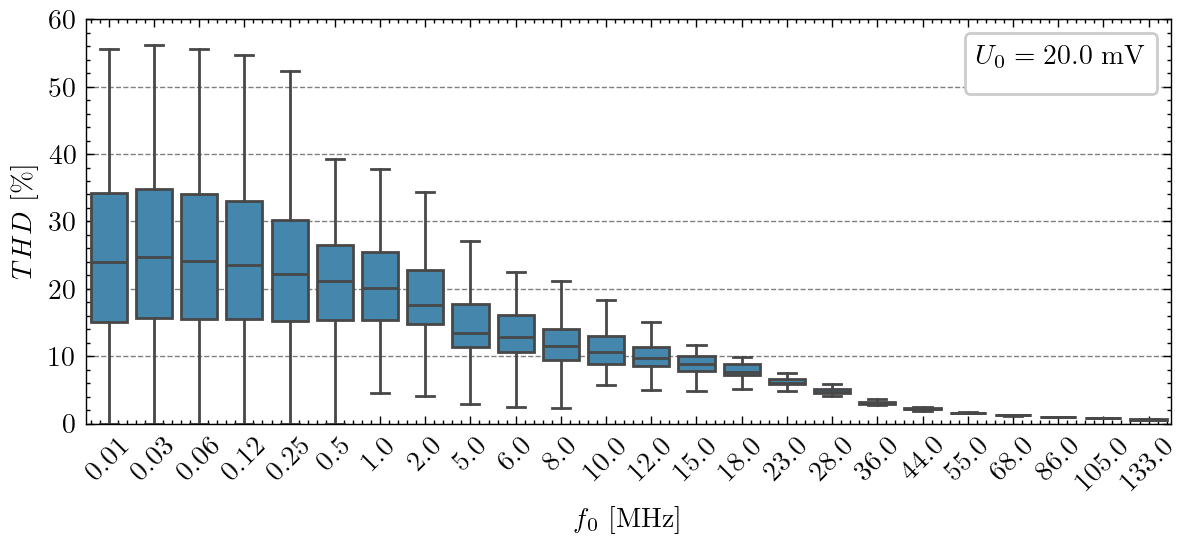

In [44]:
amp     = 0.02
fig, ax = plt.subplots(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = sns.boxplot(data=thd_net[amp], color=BLUE_COLOR, fliersize=0)
_   = ax.set_ylim(0,60)
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.set_ylabel("$THD$ [\%]")
_   = plt.xticks(rotation=45)
ax.legend(title=f"$U_0 = {amp*1000}$ mV", loc='upper right')

fig.savefig(f"plots/amp_freq/{e_type}_net_thd_vs_freq.svg", transparent=True)

### Voltage

In [45]:
AMPLITUDE_LIST  = [0.01,0.02,0.03]
FREQ_LIST_MHZ   = [0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.]  

e_type  = 'floating'
dts     = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time    = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data    = {amp : {freq : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

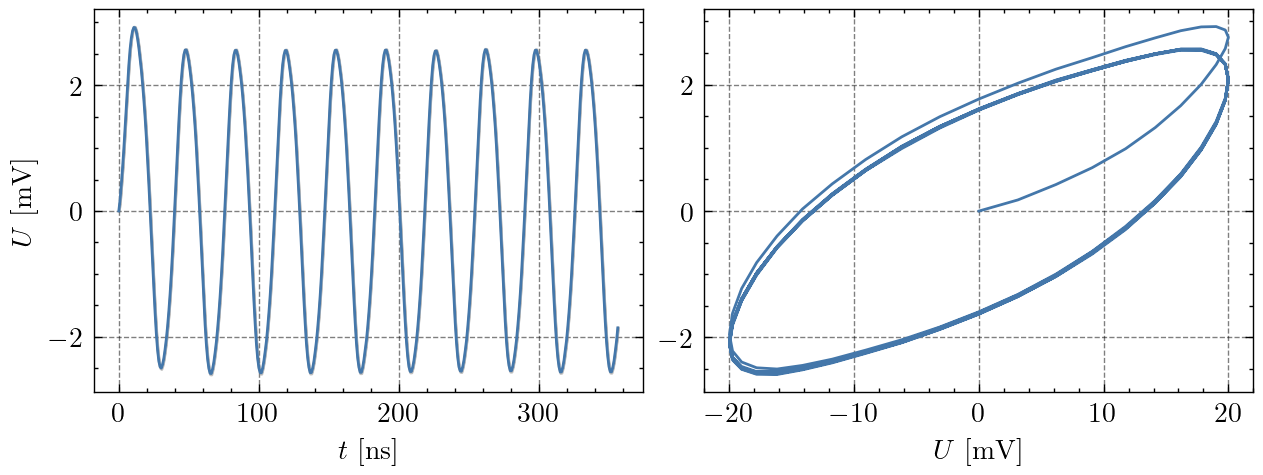

In [54]:
freq = 28.0	
amp  = 0.02
n_p  = 4
t    = time[freq][:-1]*1e9
x    = data[amp][freq]['E0'].values*1000
y    = data[amp][freq]['Observable'].values*1000
y_e  = data[amp][freq]['Error'].values*1000

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
fig.set_figheight(fig.get_figheight()*0.9)
ax1 = fig.add_subplot(1,2,1)
ax1.plot(t[:n_p*N_PERIODS], y[:n_p*N_PERIODS])
ax1.fill_between(t[:n_p*N_PERIODS], y[:n_p*N_PERIODS]-y_e[:n_p*N_PERIODS], y[:n_p*N_PERIODS]+y_e[:n_p*N_PERIODS], alpha=0.5, color='grey')
ax1.set_xlabel("$t$ [ns]")
ax1.set_ylabel("$U$ [mV]")
ax1 = fig.add_subplot(1,2,2)
ax1.plot(x[:n_p*N_PERIODS], y[:n_p*N_PERIODS])
ax1.set_xlabel("$U$ [mV]")
fig.savefig(f"plots/amp_freq/{e_type}_signal_{freq:.3f}_{amp:.3f}.svg", transparent=True)

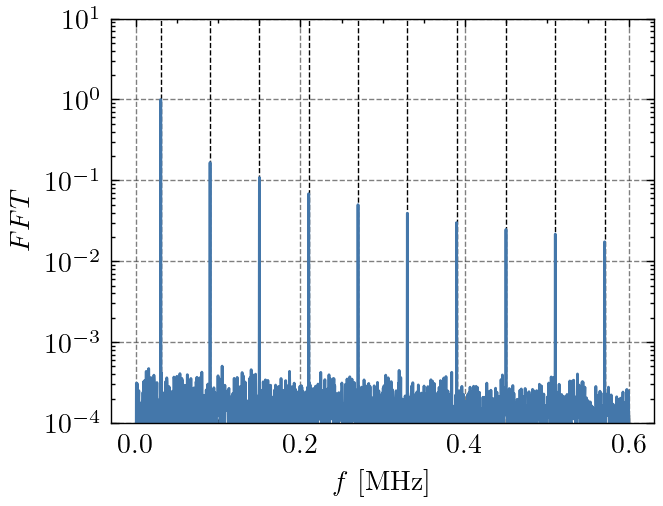

In [49]:
freq = 0.03
amp  = 0.02
n_p  = 4
dt   = dts[freq]
y    = data[amp][freq]['Observable'].values*1e-6

xf, yf  = fft(y[n_p*N_PERIODS:], dt=dt, n_padded=100)
fig, ax = plt.subplots(dpi=200)
for i in [1,3,5,7,9,11,13,15,17,19]:
    ax.vlines(i*freq, 1e-4, 1e1, color='black', ls='--', lw=.5)

ax.plot(xf*1e-6, yf/np.max(yf))
ax.set_yscale('log')
# ax.set_xlim(0.0,200)
ax.set_ylim(1e-4,1e1)
ax.set_xlabel("$f$ [MHz]")
ax.set_ylabel("$FFT$")
fig.savefig(f"plots/amp_freq/{e_type}_fft_{freq:.3f}_{amp:.3f}.svg", transparent=True)

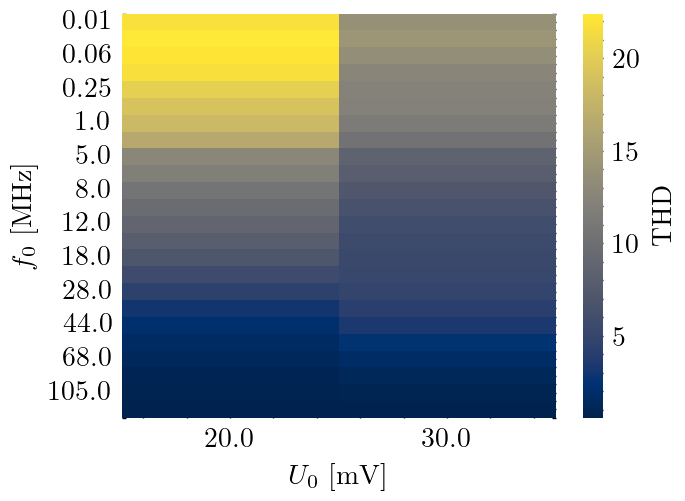

In [46]:
thd_arr = pd.DataFrame([[total_harmonic_distortion(signal=data[amp][freq]['Observable'].values, f0=freq*1e6, dt=dts[freq], N_f=18) 
                         for amp in AMPLITUDE_LIST[1:]] for freq in FREQ_LIST_MHZ], columns=np.array(AMPLITUDE_LIST[1:])*1000, index=FREQ_LIST_MHZ)
fig, ax = plt.subplots(dpi=200)
ax      = sns.heatmap(thd_arr, cmap='cividis', ax=ax, cbar_kws={'label':'THD'})
_       = plt.yticks(rotation=0)
ax.set_ylabel("$f_0$ [MHz]")
ax.set_xlabel("$U_0$ [mV]")
fig.savefig(f"plots/amp_freq/{e_type}_thd_map.svg", transparent=True)

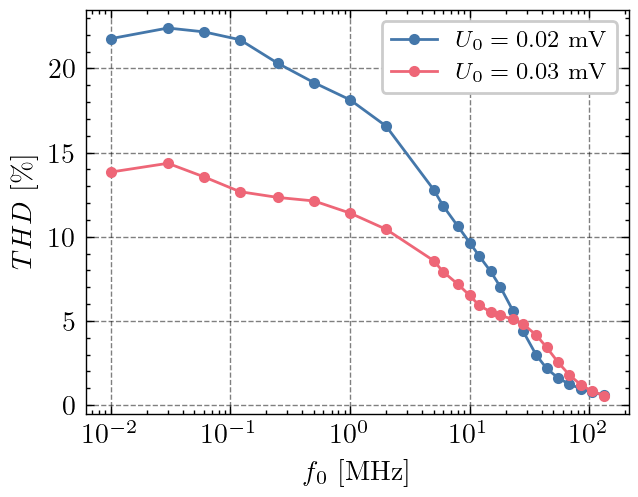

In [50]:
fig, ax = plt.subplots(dpi=200)
for amp in AMPLITUDE_LIST[1:]:
    ax.plot(thd_arr[amp*1000], '.-', label=f'$U_0 = {amp}$ mV')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$THD$ [\%]")
ax.set_xscale("log")
ax.legend(fontsize='small')
fig.savefig(f"plots/amp_freq/{e_type}_thd_vs_freq.svg", transparent=True)

In [51]:
states = {amp : {freq : pd.read_csv(f"{PATH}mean_state_Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

In [52]:
thd_net = {amp : pd.DataFrame([[total_harmonic_distortion(states[amp][freq].iloc[:,(8+i)].values, freq*1e6, dts[freq], N_f=18) for i in range(81)]
                  for freq in FREQ_LIST_MHZ], index=FREQ_LIST_MHZ).T for amp in AMPLITUDE_LIST[1:]}

/tmp/ipykernel_2891/756530536.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=f"$U_0 = {amp*1000}$ mV", loc='upper right')


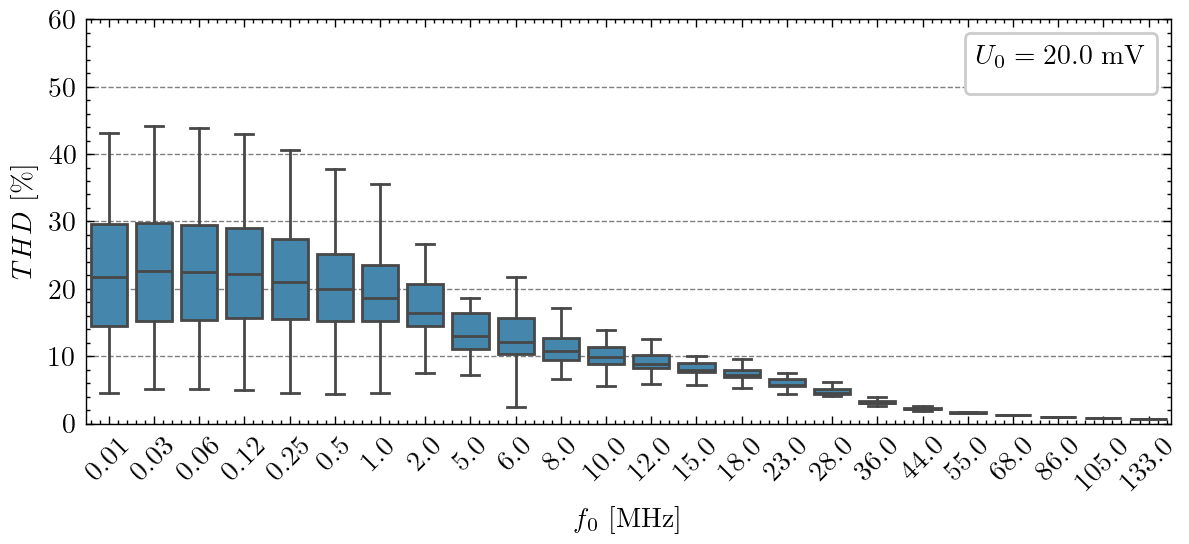

In [53]:
amp     = 0.02
fig, ax = plt.subplots(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = sns.boxplot(data=thd_net[amp], color=BLUE_COLOR, fliersize=0)
_   = ax.set_ylim(0,60)
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.set_ylabel("$THD$ [\%]")
_   = plt.xticks(rotation=45)
ax.legend(title=f"$U_0 = {amp*1000}$ mV", loc='upper right')

fig.savefig(f"plots/amp_freq/{e_type}_net_thd_vs_freq.svg", transparent=True)